## 1. load the data

In [1]:
import h5py
import numpy as np
import os
import time
print(os.listdir("./Input/train"))

['images_training.h5', 'labels_training.h5']


1.1. load the train set

In [2]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
    label_train = label_train.astype(np.uint8)
# using H['datatest'], H['labeltes t'] for test dataset.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


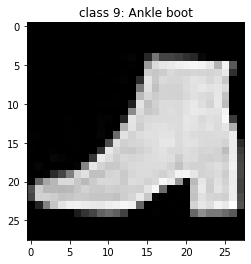

In [3]:
import matplotlib.pyplot as plt
example_train = data_train.reshape((data_train.shape[0], 28, 28))
plt.imshow(example_train[6], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[6]) + ": Ankle boot" )
plt.show()

1.1. load the test set

In [4]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
    label_test = label_test.astype(np.uint8)
# using H['datatest'], H['labeltest'] for test dataset.
print(data_test.shape,label_test.shape)

(5000, 784) (2000,)


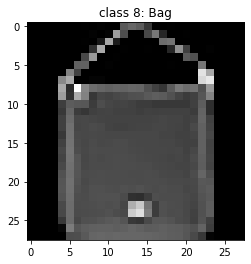

In [5]:
import matplotlib.pyplot as plt
example_test = data_test.reshape((data_test.shape[0], 28, 28))
plt.imshow(example_test[1999], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_test[1999]) + ": Bag" )
plt.show()

## 2. Preprocessing

2.1 Normalization

In [38]:
from sklearn.preprocessing import MinMaxScaler

time_start_pre = time.time()

scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

2.2 Dimensionality Reduction

apply PCA without reducing the dimensionality and compute the minimum number of dimensions (features) required for preserving 95% of the variance:

In [39]:
from sklearn.decomposition import PCA

# pca=PCA(n_components=0.95)
# data_train_reduced = pca.fit_transform(data_train)

# print("Reduced shape of training data: {}".format(str(data_train_reduced.shape)))
pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

188

In [40]:
# pca train
pca = PCA(n_components = 188)
data_train_reduced = pca.fit_transform(data_train)
data_test_reduced = pca.transform(data_test)

time_end_pre = time.time()
# data_train_recovered = pca.inverse_transform(data_train_reduced)  
print("Reduced shape of training data: {}".format(str(data_train_reduced.shape)))
print("Reduced shape of testing data: {}".format(str(data_test_reduced.shape)))
print("time cost for preprocessing",time_end_knn - time_start_knn,'s')

Reduced shape of training data: (30000, 188)
Reduced shape of testing data: (5000, 188)
time cost for preprocessing 3.882610559463501 s


In [9]:
# pca test

# data_test_recovered = pca.inverse_transform(data_test_reduced)  
# print("Reduced shape of testing data: {}".format(str(data_test_reduced.shape)))

## 3. implementation for KNN

implementation for KNN algorithm

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(data_train_reduced,label_train)
print("score: {}".format(knn.score(data_test_reduced[:2000],label_test)))

time cost for knn 0.0069811344146728516 s
score: 0.8435


10 fold - grid search((commented--details in report)

In [11]:
# param_grid = {'n_neighbors': [3,8,10],
#               'p': [2]}
# print("Parameter grid:\n{}".format(param_grid))

# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsClassifier
# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10,
#                           return_train_score=True)


# grid_search.fit(data_train_reduced, label_train)

# print("Test set score: {:.2f}".format(grid_search.score(data_test_reduced[:2000], label_test)))
# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# print("Best estimator:\n{}".format(grid_search.best_estimator_))

export the grid search result((commented--details in report))

In [12]:
# import pandas as pd
# knn_result = pd.DataFrame(grid_search.cv_results_)
# knn_result.to_csv("grid_search_knn_result.csv")

In [24]:
time_start_knn = time.time()
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(data_train_reduced,label_train)
print("score: {}".format(knn.score(data_test_reduced[:2000],label_test)))
time_end_knn = time.time()
print("time cost for knn",time_end_knn - time_start_knn,'s')

score: 0.8435
time cost for knn 3.882610559463501 s


In [43]:
y_pred_KNN = knn.predict(data_test_reduced)

0


## 4. Implementation for Decision Tree

4.1 Implementation & Apply pre-pruning

In [14]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=9, random_state=42)

tree.fit(data_train_reduced, label_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train_reduced, label_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(data_test_reduced[:2000], label_test)))

Accuracy on training set: 0.818
Accuracy on test set: 0.775


4.2 bagging

In [41]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=700,
    max_samples=500, bootstrap=True, random_state=42)
time_start_dt = time.time()
bag_clf.fit(data_train_reduced, label_train)
y_bagging_pred = bag_clf.predict(data_test_reduced[:2000])

from sklearn.metrics import accuracy_score

print("Bagging ensemble of decision trees - accuracy on test set:")
print(accuracy_score(label_test, y_bagging_pred))
time_end_dt = time.time()
print("time cost for dt:",time_end_dt - time_start_dt," s ")

Bagging ensemble of decision trees - accuracy on test set:
0.77
time cost for dt: 53.335368156433105  s 


predict

In [ ]:
y_bagging_pred = bag_clf.predict(data_test_reduced)

## 5. Implementation for Naïve Bayes

Create a GaussianNB classifier

In [42]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
time_start_nb = time.time()
nb.fit(data_train_reduced, label_train)
y_pred_GaussianNB = nb.predict(data_test_reduced[:2000])
print("Accuracy on test set: {:.3f}".format(accuracy_score(y_pred_GaussianNB, label_test)))
time_end_nb = time.time()
print("time cost of naive bayes",time_end_nb - time_start_nb,'s')

Accuracy on test set: 0.729
time cost of naive bayes 0.08178186416625977 s


Predict

In [30]:
y_pred_GaussianNB = nb.predict(data_test_reduced)

evaluate our NB classifier using 10-fold cross-validation

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

nb = GaussianNB()
scores = cross_val_score(nb, data_train_reduced, label_train, cv=10)
print("Cross-validation scores: {}".format(scores)) #accuracy for each fold
print("Average cross-validation score: {:.2f}".format(scores.mean())) #average accuracy over all folds

Cross-validation scores: [0.738      0.74633333 0.735      0.73866667 0.75166667 0.733
 0.739      0.75133333 0.756      0.75466667]
Average cross-validation score: 0.74
time cost of naive bayes 0.7918825149536133 s


## 6. Implementation for SVM

6.1 Implement SVM classifier

In [18]:
from sklearn.svm import SVC
# Linear SVM
lin_svm = SVC(kernel="linear")
time_start_svm_linear = time.time()
lin_svm.fit(data_train_reduced, label_train)
time_end_svm_linear = time.time()
y_pred_SVM = lin_svm.predict(data_test_reduced[:2000])
print("Linear SVM - accuracy on test set: {:.3f}".format(accuracy_score(y_pred_SVM, label_test)))
print("time cost for linear svm",time_end_svm_linear-time_start_svm_linear,'s')
# RBF SVM
rbf_svm = SVC(kernel="rbf", gamma="auto")
time_start_svm_rbf = time.time()
rbf_svm.fit(data_train_reduced, label_train)
time_end_svm_rbf = time.time()
y_pred_SVM = rbf_svm.predict(data_test_reduced[:2000])
print("SVM with RBF kernel - accuracy on test set: {:.3f}".format(accuracy_score(y_pred_SVM, label_test)))
print("time cost for rdf svm",time_end_svm_rbf-time_start_svm_rbf,'s')

Linear SVM - accuracy on test set: 0.843
time cost for linear svm 24.848548412322998 s
SVM with RBF kernel - accuracy on test set: 0.855
time cost for rdf svm 22.555681467056274 s


6.2 10 fold grid search based on SVM(commented--details in report)

In [19]:
# param_grid = {'C': [1],
#               'gamma': [0.004,1/188,0.006]}
# print("Parameter grid:\n{}".format(param_grid))


# # Use GridSearcCV on the training set
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# grid_search = GridSearchCV(SVC(), param_grid, cv=10,
#                           return_train_score=True)

# grid_search.fit(data_train_reduced, label_train)

# # Accuracy on test set of the model with selected best parameters:
# print("Test set score: {:.2f}".format(grid_search.score(data_test_reduced[:2000], label_test)))


# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# print("Best estimator:\n{}".format(grid_search.best_estimator_))

In [33]:
# RBF SVM
rbf_svm = SVC(kernel="rbf", gamma=0.006, C=1)
time_start_svm_rbf = time.time()
rbf_svm.fit(data_train_reduced, label_train)
print("SVM with ref kernel C=1, gama=0.006 - accuracy on test set: {:.3f}".format(accuracy_score(y_pred_SVM, label_test)))
time_end_svm_rbf = time.time()
print("time cost for rdf svm",time_end_svm_rbf-time_start_svm_rbf,'s')

SVM with ref kernel C=1, gama=0.006 - accuracy on test set: 0.855
time cost for rdf svm 22.87382960319519 s


predict

In [36]:
y_pred_SVM = rbf_svm.predict(data_test_reduced)

0


export the result table(commented--details in report)

In [20]:
# import pandas as pd
# svm_result = pd.DataFrame(grid_search.cv_results_)
# svm_result.to_csv("grid_search_svm_result.csv")

## 7.  Output the prediction

In [37]:
import numpy as np

with h5py.File('Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=y_pred_SVM)